In [49]:
from astropy.io import fits
from pathlib import Path
import os, sys

SRC_DIR = str(Path('.').resolve().parents[1])
if str(SRC_DIR) not in sys.path:
    sys.path.append(str(SRC_DIR))

import utils

import matplotlib
matplotlib.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
})

### $\xi^{(i,j)}_\theta$ definition

In [83]:
from numba import njit

@njit
def _H_LCDM(z, H0, Omega_m_0):
    return H0 * np.sqrt(Omega_m_0 * (1.0 + z)**3 + (1.0 - Omega_m_0))

@njit
def _E_LCDM(z, Omega_m_0):
    return np.sqrt(Omega_m_0 * (1.0 + z)**3 + (1.0 - Omega_m_0))

@njit
def integral_trapezoid_inv_H_LCDM(a, b, N, H0, Omega_m):
    step = (b - a) / N
    result = 0.5 * (1.0 / _E_LCDM(a, Omega_m) + 1.0 / _E_LCDM(b, Omega_m))
    for i_step in range(1, N):
        result += 1.0 / _E_LCDM(a + i_step * step, Omega_m)
    return (c / H0) * step * result

@njit
def get_chi(z, H0, Omega_m, c):
    return integral_trapezoid_inv_H_LCDM(a=0, b=z, N=1000000, H0=H0, Omega_m=Omega_m)
    
@njit
def get_z(chi_val, chi_vals, z_vals):
    i_chi = np.argmin(np.abs(chi_vals-chi_val))
    return z_vals[i_chi]

@njit
def get_n(i_bin, z, z_n_bins_list, n_bins_list):
    i_nearest = np.argmin(np.abs(z_n_bins_list - z))
    return n_bins_list[i_nearest, i_bin]

@njit
def integrand_w(chi_val_integrand, chi_val_W, chi_vals, z_n_bins_list, n_bins_list, i, H0, omega_m, c):
    z_chi_integrand = get_z(chi_val_integrand, chi_vals, z_vals)
    dz_dchi_integrand = _H_LCDM(z_chi_integrand, H0, omega_m) / c
    n_i_z = get_n(i_bin=i, z=z_chi_integrand, z_n_bins_list=z_n_bins_list, n_bins_list=n_bins_list)
    return n_i_z * dz_dchi_integrand * (chi_val_integrand - chi_val_W) / chi_val_integrand

@njit
def integral_trapezoid_w(a, b, N, chi_val_W, chi_vals, z_n_bins_list, n_bins_list, i, H0, omega_m, c):
    step = (b - a) / N
    result = 0.5 * (integrand_w(a, chi_val_W, chi_vals, z_n_bins_list, n_bins_list, i, H0, omega_m, c) + integrand_w(b, chi_val_W, chi_vals, z_n_bins_list, n_bins_list, i, H0, omega_m, c))
    for i_step in range(1, N):
        result += integrand_w(a + i_step * step, chi_val_W, chi_vals, z_n_bins_list, n_bins_list, i, H0, omega_m, c)
    return step * result

@njit
def w(i, chi_val, z_chi_val, chi_vals, z_n_bins_list, n_bins_list, chi_H, H0, omega_m, c):
    integral = integral_trapezoid_w(a=chi_val, b=chi_H, N=100, chi_val_W=chi_val, chi_vals=chi_vals, z_n_bins_list=z_n_bins_list, n_bins_list=n_bins_list, i=i, H0=H0, omega_m=omega_m, c=c)
    return 1.5 * omega_m * (H0/c)**2 * chi_val * (1+z_chi_val) * integral

@njit
def integrand_ClEE(chi_val, i, j, l, H0, omega_m, Omega_m, Omega_b, Omega_gamma, h, c, n_s, k_star, A_s, fact, chi_H, chi_vals, n_bins_list, z_n_bins_list):
    z_chi_val = get_z(chi_val=chi_val, chi_vals=chi_vals, z_vals=z_vals)
    P_cal = utils.cosmo.P(k=(l+0.5)/chi_val, z=z_chi_val, Omega_m_0=Omega_m, Omega_b_0=Omega_b, Omega_gamma=Omega_gamma, h=h, c=c, n_s=n_s, k_star=k_star, A_s=A_s, fact=fact)
    return w(i=i, chi_val=chi_val, z_chi_val=z_chi_val, chi_vals=chi_vals, z_n_bins_list=z_n_bins_list, n_bins_list=n_bins_list, chi_H=chi_H, H0=H0, omega_m=omega_m, c=c) * w(i=j, chi_val=chi_val, z_chi_val=z_chi_val, chi_vals=chi_vals, z_n_bins_list=z_n_bins_list, n_bins_list=n_bins_list, chi_H=chi_H, H0=H0, omega_m=omega_m, c=c) / (chi_val**2) * P_cal

@njit
def integral_trapezoid_ClEE(a, b, N, i, j, l, H0, omega_m, Omega_m, Omega_b, Omega_gamma, h, c, n_s, k_star, A_s, fact, chi_H, chi_vals, n_bins_list, z_n_bins_list):
    step = (b - a) / N
    result = 0.5 * (integrand_ClEE(a, i, j, l, H0, omega_m, Omega_m, Omega_b, Omega_gamma, h, c, n_s, k_star, A_s, fact, chi_H, chi_vals, n_bins_list, z_n_bins_list) + integrand_ClEE(b, i, j, l, H0, omega_m, Omega_m, Omega_b, Omega_gamma, h, c, n_s, k_star, A_s, fact, chi_H, chi_vals, n_bins_list, z_n_bins_list))
    for i_step in range(1, N):
        result += integrand_ClEE(a + i_step * step, i, j, l, H0, omega_m, Omega_m, Omega_b, Omega_gamma, h, c, n_s, k_star, A_s, fact, chi_H, chi_vals, n_bins_list, z_n_bins_list)
    return step * result

@njit
def ClEE(i, j, l, H0, omega_m, Omega_m, Omega_b, Omega_gamma, h, c, n_s, k_star, A_s, fact, chi_H, chi_vals, z_vals, n_bins_list, z_n_bins_list):
    return integral_trapezoid_ClEE(a=1e-6, b=chi_H, N=1000, i=i, j=j, l=l, H0=H0, omega_m=omega_m, Omega_m=Omega_m, Omega_b=Omega_b, Omega_gamma=Omega_gamma, h=h, c=c, n_s=n_s, k_star=k_star, A_s=A_s, fact=fact, chi_H=chi_H, chi_vals=chi_vals, n_bins_list=n_bins_list, z_n_bins_list=z_n_bins_list)

@njit
def ClBB(i, j, l):
    return 0.0

def Gp(x, l, aL_pols):
    return - ( (l-4) / (1-x**2) + 0.5 * l * (l-1) ) * aL_pols[l](x) + (l+2) * (x / (1-x**2)) * aL_pols[l-1](x)

def Gm(x, l, aL_pols):
    return 2 * ( (l-1) * x / (1-x**2) * aL_pols[l](x) - (l+2) * (1 / (1-x**2)) * aL_pols[l-1](x))

def xip(i_theta, i, j, Gp_vals, Gm_vals, H0, omega_m, Omega_m, Omega_b, Omega_gamma, h, c, n_s, k_star, A_s, fact, chi_H, chi_vals, z_vals, n_bins_list, z_n_bins_list, nb_l):
    xi = 0.0
    for l in range(2, nb_l):
        # xi_l = (2*l + 1)/(2*np.pi * l**2 * (l+1)**2) * (Gp(x=np.cos(theta), l=l, aL_pols=aL_pols) + Gm(x=np.cos(theta), l=l, aL_pols=aL_pols)) * (ClEE(i, j, l, H0, omega_m, Omega_m, Omega_b, Omega_gamma, h, c, n_s, k_star, A_s, fact, chi_H, chi_vals, z_vals, n_bins_list, z_n_bins_list) + ClBB(i, j, l))
        xi_l = (2*l + 1)/(2*np.pi * l**2 * (l+1)**2) * (Gp_vals[l, i_theta] + Gm_vals[l, i_theta]) * (ClEE(i, j, l, H0, omega_m, Omega_m, Omega_b, Omega_gamma, h, c, n_s, k_star, A_s, fact, chi_H, chi_vals, z_vals, n_bins_list, z_n_bins_list) + ClBB(i, j, l))
        print(f"xip({l}) = {xi_l}")
        xi += xi_l
        if l == nb_l - 1:
            # print(f"(2*l + 1)/(2*np.pi * l**2 * (l+1)**2) = {(2*l + 1)/(2*np.pi * l**2 * (l+1)**2)}")
            # print(f"Gp = {Gp(x=np.cos(theta), l=l, aL_pols=aL_pols)}")
            # print(f"Gm = {Gm(x=np.cos(theta), l=l, aL_pols=aL_pols)}")
            print(f"ClEE = {ClEE(i, j, l, H0, omega_m, Omega_m, Omega_b, Omega_gamma, h, c, n_s, k_star, A_s, fact, chi_H, chi_vals, z_vals, n_bins_list, z_n_bins_list)}")
            print(f"xip(l_max={l}) = {xi}")
    return xi

def xim(theta, i, j, aL_pols, H0, omega_m, Omega_m, Omega_b, Omega_gamma, h, c, n_s, k_star, A_s, fact, chi_H, chi_vals, z_vals, n_bins_list, z_n_bins_list, nb_l):
    xi = 0.0
    for l in range(2, nb_l):
        xi += (2*l + 1)/(2*np.pi * l**2 * (l+1)**2) * (Gp(x=np.cos(theta), l=l, aL_pols=aL_pols) - Gm(x=np.cos(theta), l=l, aL_pols=aL_pols)) * (ClEE(i, j, l, H0, omega_m, Omega_m, Omega_b, Omega_gamma, h, c, n_s, k_star, A_s, fact, chi_H, chi_vals, z_vals, n_bins_list) - ClBB(i, j, l))
    return xi

def chi2_desy3(des_fulldata, nb_l, Gp_vals, Gm_vals, H0, Omega_m, Omega_b, Omega_gamma, h, c, n_s, k_star, A_s, fact, chi_H, chi_vals, z_vals):
    xip_fulldata, xim_fulldata = des_fulldata[0], des_fulldata[1]
    N_xip = len(xip_fulldata[0])
    N_xim = len(xim_fulldata[0])
    N = N_xip + N_xim
    omega_m = Omega_m * h**2

    delta_xi = np.empty(N)
    for i in range(1): ## N
        if i < N_xip:
            val = xip(i_theta=i,
                                                    i=xip_fulldata[2][i],
                                                    j=xip_fulldata[3][i],
                                                    Gp_vals=Gp_vals,
                                                    Gm_vals=Gm_vals,
                                                    H0=H0,
                                                    omega_m=omega_m,
                                                    Omega_m=Omega_m,
                                                    Omega_b=Omega_b,
                                                    Omega_gamma=Omega_gamma,
                                                    h=h,
                                                    c=c,
                                                    n_s=n_s,
                                                    k_star=k_star,
                                                    A_s=A_s,
                                                    fact=fact,
                                                    chi_H=chi_H,
                                                    chi_vals=chi_vals,
                                                    z_vals=z_vals,
                                                    n_bins_list=des_fulldata[2],
                                                    z_n_bins_list=des_fulldata[3],
                                                    nb_l=nb_l)
            delta_xi[i] = xip_fulldata[0][i] - val
        elif N_xip <= i < N_xim:
            # delta_xi[i] = xim_fulldata[0][i] - xim(theta=xim_fulldata[1][i],
            #                                     i=xim_fulldata[2][i],
            #                                     j=xim_fulldata[3][i],
            #                                     aL_pols=aL_pols,
            #                                     H0=H0,
            #                                     omega_m=omega_m,
            #                                     Omega_m=Omega_m,
            #                                     Omega_b=Omega_b,
            #                                     Omega_gamma=Omega_gamma,
            #                                     h=h,
            #                                     c=c,
            #                                     n_s=n_s,
            #                                     k_star=k_star,
            #                                     A_s=A_s,
            #                                     fact=fact,
            #                                     chi_H=chi_H,
            #                                     chi_vals=chi_vals,
            #                                     z_vals=z_vals,
            #                                     n_bins_list=des_fulldata[2],
            #                                     z_n_bins_list=des_fulldata[3],
            #                                     nb_l=nb_l)
            pass

    print(f'diff={delta_xi[0]}, calculé={val}, théorique={xip_fulldata[0][i]}')
    return delta_xi @ des_fulldata[4] @ delta_xi

In [ ]:
import numpy as np

file_path = 'DES-Y3_xipm_and_KiDS-1000_COSEBIs_2.0_300.0.fits'

with fits.open(file_path) as hdul:
    # hdul.info()
    xip_data = hdul['xip'].data
    xim_data = hdul['xim'].data
    covmat = hdul['COVMAT'].data
    nz_data_des = hdul['nz_source_des'].data
    nz_source_kids = hdul['nz_source_kids'].data

z_vals_des = nz_data_des['Z_MID']
covmat_desy3 = covmat[:400, :400]
covmat_kids = covmat[400:, 400:]

z_vals_kids = nz_source_kids['Z_MID']
n_bin1 = nz_data_des['BIN1']

xi_minus_data = xim_data['VALUE']
xi_minus_ang = xim_data['ANG']
xi_plus_data = xip_data['VALUE']
xi_plus_ang = xip_data['ANG']

nb_l = 1000

H0 = 73.4
h = 0.674
c = 299792.458
Omega_m = 0.315
Omega_b = 0.049
Omega_gamma = 2.47e-5 / h**2
n_s = 2.1e-9
n_s = 0.965
k_star = 0.05

A_s = 2.1e-9

z_max_horizon = 1e4
chi_H = get_chi(z_max_horizon, H0, Omega_m, c)
# chi_H = 1e4
print(f"chi_H={chi_H}")

N_eff = 3.046
R_nu = (0.2271 * N_eff) / (1 + 0.2271 * N_eff) # 0.2271 = 7/8*(4/11)**(4/3)
fact = 1 / (1 + (4/15) * R_nu)
fact *= 0.855 ## temporary to fit with CLASS

z_vals = np.logspace(-10, np.log10(10), 1000)
chi_vals = get_chi(z=z_vals, H0=H0, Omega_m=Omega_m, c=c)

polynoms = utils.polynoms.AssociatedLegendrePolynomsCalculator(nb_l).polynoms


des_xip_fulldata = [xip_data['VALUE'], # xip
                    xip_data['ANG'], # theta
                    xip_data['BIN1'], # i
                    xip_data['BIN2'], # j
                    ]

des_xim_fulldata = [xim_data['VALUE'], # xim
                    xim_data['ANG'], # theta
                    xim_data['BIN1'], # i
                    xim_data['BIN2'], # j
                    ]

des_fulldata = [des_xip_fulldata,
                des_xim_fulldata,
                np.column_stack((nz_data_des['BIN1'].astype(np.float64),  # n_i(z) for i = 1
                                nz_data_des['BIN2'].astype(np.float64),   # ...
                                nz_data_des['BIN3'].astype(np.float64),   # ...
                                nz_data_des['BIN4'])).astype(np.float64), # n_i(z) for i = 4
                nz_data_des['Z_MID'].astype(np.float64),                  # z in n_i(z)
                covmat_desy3,
                ]

Gp_vals, Gm_vals, P_l2 = precalc_Gp_Gm_from_recurrence(xip_data['ANG'], l_max=nb_l)

res = chi2_desy3(des_fulldata=des_fulldata,
        nb_l=nb_l,
        Gp_vals=Gp_vals,
        Gm_vals=Gm_vals,
        H0=H0,
        Omega_m=Omega_m,
        Omega_b=Omega_b,
        Omega_gamma=Omega_gamma,
        h=h,
        c=c,
        n_s=n_s,
        k_star=k_star,
        A_s=A_s,
        fact=fact,
        chi_H=chi_H,
        chi_vals=chi_vals,
        z_vals=z_vals)

chi_H=13088.569604480805


/home/vicpabo/Documents/Projects/Stage-irap/programs/src/utils/polynoms.py:81: RuntimeWarning: overflow encountered in multiply
  self.coeffs *= scalar
/home/vicpabo/Documents/Projects/Stage-irap/programs/src/utils/polynoms.py:69: RuntimeWarning: overflow encountered in scalar add
  res[i] += p.coeffs[i]


xip(2) = 3.8018822093364265e-15
xip(3) = -3.84952551694897e-14
xip(4) = 1.7362586724579818e-13
xip(5) = -5.32787481729797e-13
xip(6) = 1.292233763158069e-12
xip(7) = -2.6646706097136802e-12
xip(8) = 4.869288355747749e-12
xip(9) = -8.091753212393572e-12
xip(10) = 1.243993878963268e-11
xip(11) = -1.7902384698868786e-11
xip(12) = 2.431666156373048e-11
xip(13) = -3.135397144388557e-11
xip(14) = 3.852451813857786e-11
xip(15) = -4.520565957477199e-11
xip(16) = 5.0691914959002255e-11
xip(17) = -5.426290919508881e-11
xip(18) = 5.526267523824769e-11
xip(19) = -5.318174800715196e-11
xip(20) = 4.773244356579027e-11
xip(21) = -3.89077895859087e-11
xip(22) = 2.7015794432148487e-11
xip(23) = -1.2683014835681226e-11
xip(24) = -3.1755172197266777e-12
xip(25) = 1.9419344426856023e-11
xip(26) = -3.477423307745148e-11
xip(27) = 4.7944634681039464e-11
xip(28) = -5.773646414236977e-11
xip(29) = 6.317801346700739e-11
xip(30) = -6.362638193496121e-11
xip(31) = 5.884770360108814e-11
xip(32) = -4.9061638649881

In [78]:
import numpy as np

def precalc_Gp_Gm_from_recurrence(theta, l_max, eps=1e-12):
    theta = np.asarray(theta)
    x = np.cos(theta)
    ntheta = x.size

    one_minus_x2 = np.clip(1.0 - x**2, eps, None)

    P_l2 = np.zeros((l_max + 1, ntheta), dtype=float)

    m = 2
    if l_max < m:
        Gp = np.zeros_like(P_l2)
        Gm = np.zeros_like(P_l2)
        return Gp, Gm, P_l2

    # Base: P_m^m(x) = (-1)^m (2m-1)!! (1-x^2)^{m/2}
    # for m=2: (2m-1)!! = 3, sign = (+1) because (-1)^2 = 1
    P_l2[m, :] = 3.0 * one_minus_x2  # P_2^2(x) = 3 (1-x^2)

    # P_{m+1}^m = (2m+1) x P_m^m
    if l_max >= m + 1:
        P_l2[m + 1, :] = (2 * m + 1) * x * P_l2[m, :]

    for l in range(m + 1, l_max):
        numer = (2 * l + 1) * x * P_l2[l, :] - (l + m) * P_l2[l - 1, :]
        denom = (l - m + 1)
        P_l2[l + 1, :] = numer / denom

    Gp = np.zeros_like(P_l2)
    Gm = np.zeros_like(P_l2)

    inv_1mx2 = 1.0 / one_minus_x2
    x_over_1mx2 = x * inv_1mx2

    for l in range(2, l_max + 1):
        Pl2 = P_l2[l, :]
        Plm1_2 = P_l2[l - 1, :] if l - 1 >= 0 else np.zeros(ntheta)
        # Gp(x,l) = - ( (l-4) / (1-x^2) + 0.5 * l * (l-1) ) * P_l^2(x)
        #           + (l+2) * ( x / (1-x^2) ) * P_{l-1}^2(x)
        Gp[l, :] = - ( (l - 4.0) * inv_1mx2 + 0.5 * l * (l - 1.0) ) * Pl2 \
                   + (l + 2.0) * x_over_1mx2 * Plm1_2

        # Gm(x,l) = 2 * ( (l-1) * x/(1-x^2) * P_l^2(x) - (l+2) * 1/(1-x^2) * P_{l-1}^2(x) )
        Gm[l, :] = 2.0 * ( (l - 1.0) * x_over_1mx2 * Pl2 - (l + 2.0) * inv_1mx2 * Plm1_2 )

    return Gp, Gm, P_l2

nb_l = 5
l = 2
i_theta = 2
theta = xip_data['ANG'][i_theta]

Gp_vals, Gm_vals, P_l2 = precalc_Gp_Gm_from_recurrence(xip_data['ANG'], l_max=nb_l)
print(f'Precalculated G_p(l=2, theta={theta:.1f}) = {Gp_vals[l, i_theta]:.1f}')

aL_pols = utils.polynoms.AssociatedLegendrePolynomsCalculator(nb_l).polynoms
print(f'OG G_p(l=2, theta={theta:.1f}) = {Gp(theta, l, aL_pols):.1f}')

Precalculated G_p(l=2, theta=4.5) = 3.2
OG G_p(l=2, theta=4.5) = 23326.8


# Checks

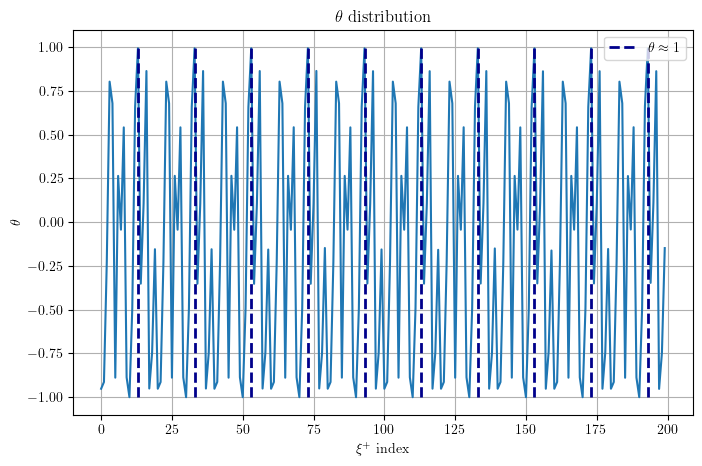

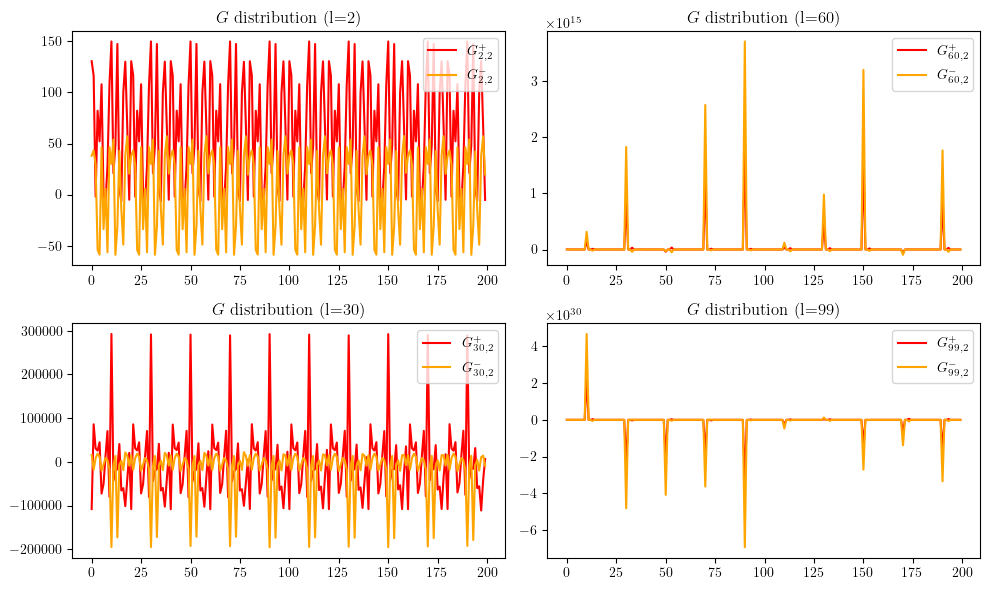

In [63]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.animation as animation

file_path = 'DES-Y3_xipm_and_KiDS-1000_COSEBIs_2.0_300.0.fits'

with fits.open(file_path) as hdul:
    # hdul.info()
    xip_data = hdul['xip'].data
    xim_data = hdul['xim'].data
    covmat = hdul['COVMAT'].data
    nz_data_des = hdul['nz_source_des'].data
    nz_source_kids = hdul['nz_source_kids'].data

covmat_desy3 = covmat[:400, :400]
covmat_kids = covmat[400:, 400:]

des_xip_fulldata = [xip_data['VALUE'], # xip
                    xip_data['ANG'], # theta
                    xip_data['BIN1'], # i
                    xip_data['BIN2'], # j
                    ]

des_xim_fulldata = [xim_data['VALUE'], # xim
                    xim_data['ANG'], # theta
                    xim_data['BIN1'], # i
                    xim_data['BIN2'], # j
                    ]

des_fulldata = [des_xip_fulldata,
                des_xim_fulldata,
                np.column_stack((nz_data_des['BIN1'].astype(np.float64),  # n_i(z) for i = 1
                                nz_data_des['BIN2'].astype(np.float64),   # ...
                                nz_data_des['BIN3'].astype(np.float64),   # ...
                                nz_data_des['BIN4'])).astype(np.float64), # n_i(z) for i = 4
                nz_data_des['Z_MID'].astype(np.float64),                  # z in n_i(z)
                covmat_desy3,
                ]

nb_l = 100
xi_range = np.arange(200)

### Theta distribution

cos_thetas = np.cos(des_xip_fulldata[1])
aL_pols = utils.polynoms.AssociatedLegendrePolynomsCalculator(nb_l).polynoms

plt.figure(figsize=(8,5))
plt.plot(xi_range, cos_thetas)
plt.xlabel(r'$\xi^+$ index')
plt.ylabel(r'$\theta$')
plt.title(r'$\theta$ distribution')
plt.grid(True, which='both')

threshold = 0.95
thetas_approx_1 = []
for i, value in enumerate(cos_thetas):
    if value > threshold:
        # print(f'cos(theta) = {value}, 1/(1-cos²(theta) = {1/(1-value**2)}')
        thetas_approx_1.append(xi_range[i])

plt.vlines(thetas_approx_1, -1, 1, colors='darkblue', label=r'$\theta \approx 1$', linestyles='--', linewidth=2)
plt.legend()

### G distribution

fig, ax = plt.subplots(2, 2, figsize=(10, 6))

Gp_calc = Gp(cos_thetas, 2, aL_pols)
Gm_calc = Gm(cos_thetas, 2, aL_pols)

ax[0,0].plot(xi_range, Gp_calc, color='r', label=r'$G^+_{2,2}$')
ax[0,0].plot(xi_range, Gm_calc, color='orange', label=r'$G^-_{2,2}$')
ax[0,0].legend()
ax[0,0].set_title(r'$G$ distribution (l=2)')

Gp_calc2 = Gp(cos_thetas, 30, aL_pols)
Gm_calc2 = Gm(cos_thetas, 30, aL_pols)

ax[1,0].plot(xi_range, Gp_calc2, color='r', label=r'$G^+_{30,2}$')
ax[1,0].plot(xi_range, Gm_calc2, color='orange', label=r'$G^-_{30,2}$')
ax[1,0].legend()
ax[1,0].set_title(r'$G$ distribution (l=30)')

Gp_calc2 = Gp(cos_thetas, 60, aL_pols)
Gm_calc2 = Gm(cos_thetas, 60, aL_pols)

ax[0,1].plot(xi_range, Gp_calc2, color='r', label=r'$G^+_{60,2}$')
ax[0,1].plot(xi_range, Gm_calc2, color='orange', label=r'$G^-_{60,2}$')
ax[0,1].legend()
ax[0,1].set_title(r'$G$ distribution (l=60)')

Gp_calc2 = Gp(cos_thetas, 99, aL_pols)
Gm_calc2 = Gm(cos_thetas, 99, aL_pols)

ax[1,1].plot(xi_range, Gp_calc2, color='r', label=r'$G^+_{99,2}$')
ax[1,1].plot(xi_range, Gm_calc2, color='orange', label=r'$G^-_{99,2}$')
ax[1,1].legend()
ax[1,1].set_title(r'$G$ distribution (l=99)')
threshold = 0.95
for i, value in enumerate(cos_thetas):
    if value > threshold:
        ax[1,1].vlines(xi_range[i], -1, value, linewidth=100)
plt.tight_layout()
plt.show()

In [56]:
nb_l = 100
polynoms = utils.polynoms.AssociatedLegendrePolynomsCalculator(nb_l).polynoms
print(polynoms[-1])

<Polynom deg=101, coeffs=[ 0.00000000e+00 -8.27966837e+04  0.00000000e+00  1.42079109e+08
  0.00000000e+00 -7.30713024e+10  0.00000000e+00  1.78642072e+13
  0.00000000e+00 -2.54118752e+15  0.00000000e+00  2.35822849e+17
  0.00000000e+00 -1.53678537e+19  0.00000000e+00  7.40295910e+20
  0.00000000e+00 -2.73748412e+22  0.00000000e+00  7.99802087e+23
  0.00000000e+00 -1.88870088e+25  0.00000000e+00  3.67145674e+26
  0.00000000e+00 -5.96379033e+27  0.00000000e+00  8.19658764e+28
  0.00000000e+00 -9.63227650e+29  0.00000000e+00  9.76517816e+30
  0.00000000e+00 -8.60589919e+31  0.00000000e+00  6.63624221e+32
  0.00000000e+00 -4.50311143e+33  0.00000000e+00  2.70202514e+34
  0.00000000e+00 -1.43974771e+35  0.00000000e+00  6.83732031e+35
  0.00000000e+00 -2.90299744e+36  0.00000000e+00  1.10490816e+37
  0.00000000e+00 -3.77831950e+37  0.00000000e+00  1.16297000e+38
  0.00000000e+00 -3.22686197e+38  0.00000000e+00  8.08028099e+38
  0.00000000e+00 -1.82747139e+39  0.00000000e+00  3.73464939e+39


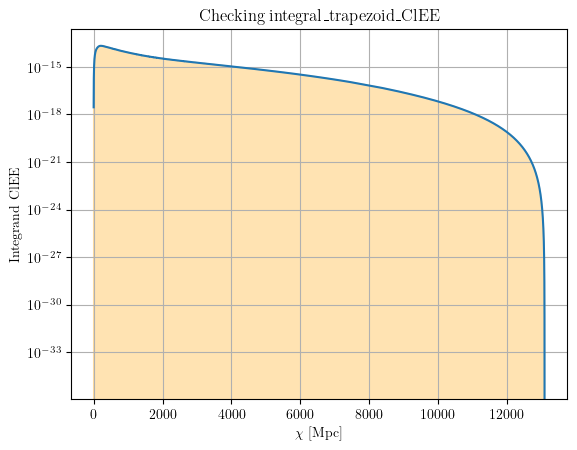

Integral value (np.trapz) = 2.4424128016976282e-11
Integral value (integral_trapezoid_ClEE) = 2.442377898890694e-11


In [ ]:
from matplotlib import pyplot as plt
import numpy as np

chi_vals_but_not_chi_vals = np.linspace(1, chi_H, 100000)
vals = [integrand_ClEE(xx,
                       des_xip_fulldata[2][0], des_xip_fulldata[3][0], 2,
                       H0, Omega_m*h**2, Omega_m, Omega_b, Omega_gamma,
                       h, c, n_s, k_star, A_s, fact,
                       chi_H, chi_vals, des_fulldata[2], des_fulldata[3]) 
        for xx in chi_vals_but_not_chi_vals]

integrale = np.trapz(vals, chi_vals_but_not_chi_vals)

integrale_v2 = integral_trapezoid_ClEE(a=1e-6, b=chi_H, N=1000, i=des_xip_fulldata[2][0], j=des_xip_fulldata[3][0],
                                        l=2, H0=H0, omega_m=Omega_m*h**2, Omega_m=Omega_m, Omega_b=Omega_b,
                                        Omega_gamma=Omega_gamma, h=h, c=c, n_s=n_s, k_star=k_star, A_s=A_s,
                                        fact=fact, chi_H=chi_H, chi_vals=chi_vals, n_bins_list=des_fulldata[2],
                                        z_n_bins_list=des_fulldata[3])


plt.plot(chi_vals_but_not_chi_vals, vals)
plt.fill_between(chi_vals_but_not_chi_vals, vals, alpha=0.3, color="orange")

plt.xlabel(r"$\chi$ [Mpc]")
plt.ylabel("Integrand ClEE")
plt.yscale("log")
plt.grid(True)
plt.title('Checking integral_trapezoid_ClEE')
plt.show()

print("Integral value (np.trapz) =", integrale)
print("Integral value (integral_trapezoid_ClEE) =", integrale_v2)


## Comparison plots

-1.0039920763292391 -0.941865954665012 -0.9645675520018693
0.9729290154971255


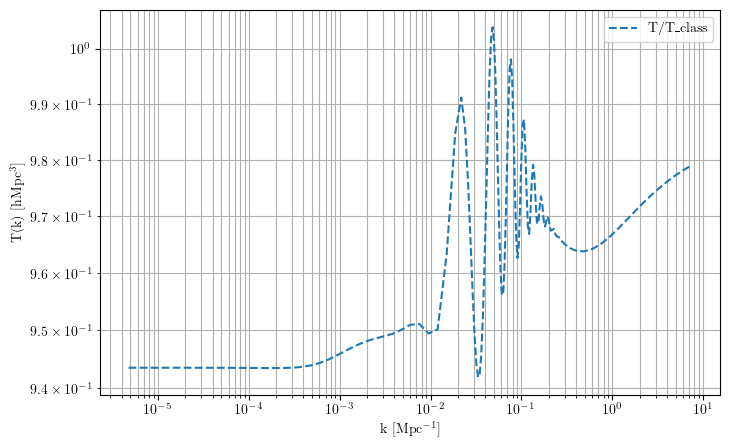

In [53]:
from classy import Class
import numpy as np
from matplotlib import pyplot as plt
from numba import njit

### PARAMETERS

c = 299792.458
h = 0.674
Omega_m = 0.315
Omega_b = 0.049
Omega_gamma = 2.47e-5 / h**2
A_s = 2.1e-9
n_s = 0.965
k_pivot = 0.05   # 1/Mpc
z = 5 # entre 0 et 6 pour KiDS (0 et 3 pour DESy3)
N_eff = 3.046
R_nu = (0.2271 * N_eff) / (1 + 0.2271 * N_eff) # 0.2271 = 7/8*(4/11)**(4/3)
fact = 1 / (1 + (4/15) * R_nu)
fact *= 0.855 ## temporary to fit with CLASS

### CLASS
cosmo = Class()
cosmo.set({
    'h': h,
    'omega_b': Omega_b * h**2,
    'omega_cdm': (Omega_m - Omega_b) * h**2,
    'A_s': A_s,
    'n_s': n_s,
    'output': 'dTk,mPk',
    'P_k_max_1/Mpc': 10.0,
    'z_max_pk': 5.0
})
cosmo.compute()

transfer, k_grid, z_grid = cosmo.get_transfer_and_k_and_z()

compare = {
    'T-T_class': True,
    'P(T_class)-P_class': False,
    'P-P_class': False
}

iz = np.argmin(np.abs(z_grid - z))

if compare['P(T_class)-P_class']:
    plt.figure(figsize=(8,5))
    P_cal = utils.cosmo._P_k_z(k=k_grid, A_s=A_s, k_star=k_pivot, n_s=n_s, Tdm=transfer['d_m'][:, iz])
    P_class = np.array([cosmo.pk_lin(k, z) for k in k_grid])
    ratio = P_cal / P_class
    print(ratio.min(), ratio.max(), ratio.mean())
    plt.loglog(h*k_grid, P_class, label='P_class')
    plt.loglog(h*k_grid, P_cal, label='P(T_class)')
    plt.loglog(h*k_grid, P_cal/P_class, '--', label='P(T_class)/P_class')
    plt.grid(True, which='both')
    plt.xlabel('k [Mpc$^{-1}$]')
    plt.ylabel('P(k) [hMpc$^3$]')
    plt.legend();
if compare['T-T_class']:
    plt.figure(figsize=(8,5))
    T = utils.cosmo._T_k_z(k=k_grid, z=z, Omega_m_0=Omega_m, Omega_b_0=Omega_b, Omega_gamma=Omega_gamma, h=h, c=c, fact=fact)
    T_class = transfer['d_m'][:, iz]
    ratio = T / T_class
    print(ratio.min(), ratio.max(), ratio.mean())
    print(0.5*(np.abs(ratio).min()+np.abs(ratio).max()))
    # plt.loglog(h*k_grid, -T_class, label='T_class')
    # plt.loglog(h*k_grid, T, label='T')
    plt.loglog(h*k_grid, -T/T_class, '--', label='T/T_class')
    plt.grid(True, which='both')
    plt.xlabel('k [Mpc$^{-1}$]')
    plt.ylabel('T(k) [hMpc$^3$]')
    plt.legend();
if compare['P-P_class']:
    plt.figure(figsize=(8,5))
    # T = utils.T_k_z(k=k_grid, z=z, Omega_m_0=Omega_m, Omega_b_0=Omega_b, Omega_gamma=Omega_gamma, h=h, c=c, fact=fact)
    # P = utils.P_k_z(k=k_grid, A_s=A_s, k_star=k_pivot, n_s=n_s, Tdm=T)
    P_cal = utils.cosmo.P(k_grid, z, Omega_m, Omega_b, Omega_gamma, h, c, n_s, k_pivot, A_s, fact)
    P_class = np.array([cosmo.pk_lin(k, z) for k in k_grid])
    ratio = P_cal / P_class
    print(ratio.min(), ratio.max(), ratio.mean())
    plt.loglog(h*k_grid, P_class, label='P_class')
    plt.loglog(h*k_grid, P_cal, label='P')
    plt.loglog(h*k_grid, P_cal/P_class, '--', label='P/P_class')
    plt.grid(True, which='both')
    plt.xlabel('k [hMpc$^{-1}$]')
    plt.ylabel('P(k) [Mpc$^3$]')
    plt.legend();

/tmp/ipykernel_20626/942024579.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("YlOrRd")


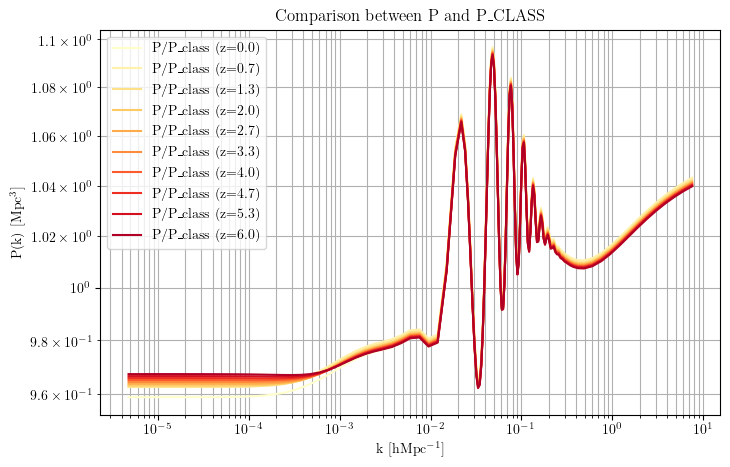

In [54]:
from matplotlib import cm  # colormaps
from matplotlib.colors import Normalize

cosmo = Class()
cosmo.set({
    'h': h,
    'omega_b': Omega_b * h**2,
    'omega_cdm': (Omega_m - Omega_b) * h**2,
    'A_s': A_s,
    'n_s': n_s,
    'output': 'mPk',

    'P_k_max_1/Mpc': 10.0,
    'z_max_pk': 5.0,
})
cosmo.compute()

k_vals = np.logspace(-3, 1, 124)

# Tracer
plt.figure(figsize=(8,5))
Nz = 10
z_array = np.linspace(0,6,Nz)

norm = Normalize(vmin=0, vmax=Nz)
cmap = cm.get_cmap("YlOrRd")
for i in range(len(z_array)):
    z = z_array[i]
    T = utils.cosmo._T_k_z(k=k_grid, z=z, Omega_m_0=Omega_m, Omega_b_0=Omega_b, Omega_gamma=Omega_gamma, h=h, c=c, fact=fact)
    P = utils.cosmo._P_k_z(k=k_grid, A_s=A_s, k_star=k_pivot, n_s=n_s, Tdm=T)
    P_class = np.array([cosmo.pk_lin(k, z) for k in k_grid])
    ratio = P / P_class
    plt.loglog(h*k_grid, P/P_class, color=cmap(norm(i)), label=f'P/P_class (z={z:.1f})')

plt.legend(); plt.xlabel('k [hMpc$^{-1}$]'); plt.ylabel('P(k) [Mpc$^3$]')
plt.title(f'Comparison between P and P_CLASS')
plt.grid(True, which='both')
plt.show()
